In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector, Parameter
from qiskit_algorithms.optimizers import COBYLA
import numpy as np
import math
import matplotlib.pyplot as plt

### Layers

In [2]:
def encoding_layer(num_address_qubits, num_embedding_qubits, theta_params):
    encoding_layer = QuantumCircuit(num_address_qubits + num_embedding_qubits)

    # Unitary operations to encode the input data
    for i in range(num_address_qubits):
        encoding_layer.cry(theta_params[i], control_qubit=i, target_qubit=num_address_qubits)

    return encoding_layer

def mixing_layer(num_address_qubits, num_embedding_qubits):
    mixing_layer = QuantumCircuit(num_address_qubits + num_embedding_qubits)

    # TODO: is this important?
    mixing_layer.x(num_address_qubits - 1)

    # CNOT gates to mix the address register qubits
    for i in range(num_address_qubits - 1):
        mixing_layer.cx(i, i + 1)

    return mixing_layer

def measurement_layer(num_address_qubits, num_embedding_qubits):
    measurement_layer = QuantumCircuit(num_address_qubits + num_embedding_qubits)
    cr_measurement = ClassicalRegister(num_address_qubits, name='meas')
    measurement_layer.add_register(cr_measurement)

    # Apply the measurement layer rotations to the address register qubits
    for i in range(num_address_qubits):
        measurement_layer.ry(np.pi / 2, i)

    # Measure only the address register qubits
    for i in range(num_address_qubits):
        measurement_layer.measure(i, cr_measurement[i])

    return measurement_layer

### Circuit

In [3]:
def create_circuit(num_address_qubits, num_embedding_qubits, pqc_m):

    # Create the quantum circuit
    qc = QuantumCircuit(QuantumRegister(num_address_qubits, name='address'), QuantumRegister(num_embedding_qubits, name='embedding'))
    cr_measurement = ClassicalRegister(num_address_qubits, name='measurement')
    qc.add_register(cr_measurement)

    # Apply Hadamard gates to the address register qubits to create a superposition
    for i in range(num_address_qubits):
        qc.h(i)

    # Parameterized quantum circuit (PQC)
    for i in range(pqc_m):
        theta_params = [Parameter(f'theta_{i}_{j}') for j in range(num_address_qubits)]
        qc.barrier()
        qc.compose(encoding_layer(num_address_qubits, num_embedding_qubits, theta_params), inplace=True)
        qc.barrier()
        qc.compose(mixing_layer(num_address_qubits, num_embedding_qubits), inplace=True)

    # Apply the measurement layer
    qc.barrier()
    qc.compose(measurement_layer(num_address_qubits, num_embedding_qubits), inplace=True)

    return qc

### Optimizer

In [4]:
def estimate_inner_products_from_measurements(counts, num_nodes):
    num_address_qubits = math.ceil(np.log2(num_nodes))

    # Initialize inner product estimates
    inner_products = np.zeros((num_nodes, num_nodes))

    # Convert counts to probabilities
    total_counts = sum(counts.values())
    probabilities = {state: count / total_counts for state, count in counts.items()}

    # Iterate over all possible address register states
    for i in range(num_nodes):
        for j in range(num_nodes):
            # Convert to bit strings
            bitstring_i = format(i, f'0{num_address_qubits}b')
            bitstring_j = format(j, f'0{num_address_qubits}b')

            # For simplicity, we consider the probability of each state as the magnitude of its amplitude squared
            prob_i = probabilities.get(bitstring_i, 0)
            prob_j = probabilities.get(bitstring_j, 0)

            # Estimate inner products based on classical probabilities
            inner_products[i, j] = np.sqrt(prob_i * prob_j)

    return inner_products

def objective_function(circuit, simulator, theta_vector, adjacency_matrix, gamma, scores):

    # Assign parameters to the circuit and execute it
    bound_circuit = circuit.assign_parameters(theta_vector)
    job = simulator.run(bound_circuit, shots=8192)
    counts = job.result().get_counts()

    estimated_inner_products = estimate_inner_products_from_measurements(counts, len(adjacency_matrix))

    # Calculate the loss based on the estimated inner products
    loss = 0
    max_loss =  np.sum(adjacency_matrix) - np.sum(np.diag(adjacency_matrix))

    for i in range(len(adjacency_matrix)):
        for j in range(len(adjacency_matrix)):
            if i != j:  # Exclude self-loops
                A_ij = adjacency_matrix[i, j]
                inner_product = estimated_inner_products[i, j]
                # Adjust the loss calculation for the deviation from the theoretical maximum
                loss += A_ij * (1 - inner_product) - gamma * (1 - A_ij) * inner_product

    # Scale and shift the loss from [-1, 1]
    normalized_loss = loss / max_loss * 2 - 1

    scores.append(normalized_loss)

    return normalized_loss

### Embedding

In [5]:
def embed(adjacency_matrix, gamma, scores, pqc_m):
    num_address_qubits = math.ceil(np.log2(len(adjacency_matrix)))

    num_embedding_qubits = 1
    circuit = create_circuit(num_address_qubits, num_embedding_qubits, pqc_m)

    # plot the circuit
    display(circuit.draw('mpl'))

    simulator = Aer.get_backend('aer_simulator')
    circuit = transpile(circuit, simulator)

    optimizer = COBYLA(maxiter=250)
    theta_initial = np.full(num_address_qubits * pqc_m, np.pi)
    opt_result = optimizer.minimize(lambda theta_values: -objective_function(circuit, simulator, theta_values, adjacency_matrix, gamma, scores), theta_initial)

    # bound to 0 to 2pi
    optimal_theta = np.mod(opt_result.x, 2 * np.pi)

    print(f'Optimal theta: {optimal_theta}')

/Users/andycaen/opt/anaconda3/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


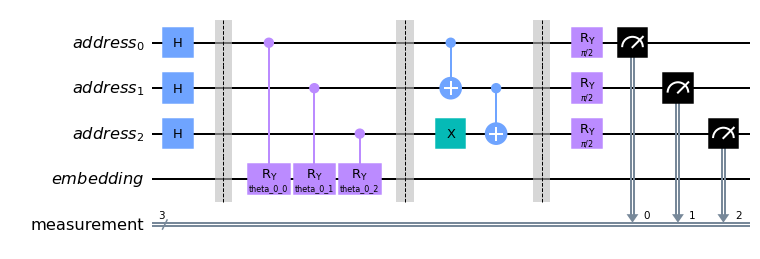

Optimal theta: [6.17237304 3.73749946 0.01270694]


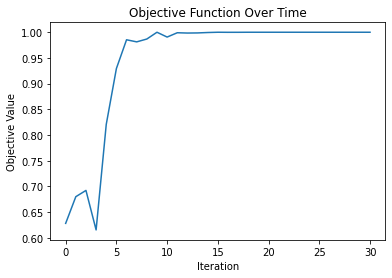

In [6]:
adjacency_matrix = np.array([[0, 1, 1, 0, 1], [1, 0, 1, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 1], [0, 0, 0, 1, 0]])
gamma = 0.5
pqc_m = 1
scores = []

embed(adjacency_matrix, gamma, scores, pqc_m)

plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Function Over Time')
plt.show()